In [68]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from matplotlib.pyplot import figure
import statsmodels.api as sm

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # We display the first 3 factorial planes, therefore the first 6 components
        if d2 < n_comp:

            # figure initialization
            fig, ax = plt.subplots(figsize=(7,6))

            # determining the limits of the graph
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # display arrows
            # if there are more than 30 arrows, the triangle is not displayed at their end
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:],
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # display variable names
            if labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # circle display
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # set graph limits
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # display horizontal and vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # names of the axes, with the percentage of inertia explained
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Circle of correlations (F{} and F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # figure initialization
            fig = plt.figure(figsize=(7,6))
        
            # display of points
            if illustrative_var is None:
                plt. scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # display point labels
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center', va='center')
                
            # determining the limits of the graph
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 0.5
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # display horizontal and vertical lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # names of the axes, with the percentage of inertia explained
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of individuals (on F{} and F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("axis of inertia rank")
    plt.ylabel("inertia percentage")
    plt.title("Scree of eigenvalues")
    plt.show(block=False)

In [71]:
def Nutriscore(df):

  #Sets a value from A to E depending on the value of nutrition-score-fr_100g
  conditions = [
    (df['nutrition-score-fr_100g'] < 4),
    (df['nutrition-score-fr_100g'] >= 4) & (df['nutrition-score-fr_100g'] < 9),
    (df['nutrition-score-fr_100g'] >= 9) & (df['nutrition-score-fr_100g'] < 12),
    (df['nutrition-score-fr_100g'] >= 12) & (df['nutrition-score-fr_100g'] < 18),
    (df['nutrition-score-fr_100g'] >= 18)
    ]
  values = ['E', 'D', 'C', 'B', 'A']

  #Assigns the value from A to E
  df['Nutrigrade'] = np.select(conditions, values)

  return df

In [72]:
def PCA_Analysis(names, data_pca, n_comp):

  # data preparation for PCA
  X = data_pca.values
  features = data_pca.columns

  # Centering and Reduction
  std_scale = preprocessing.StandardScaler().fit(X)
  X_scaled = std_scale.transform(X)

  # Calculation of principal components
  pca = decomposition.PCA(n_components=n_comp)
  pca.fit(X_scaled)

  # Eigenvalue scree
  display_scree_plot(pca)

  # Circle of correlations
  pcs = pca.components_
  display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

  # Projection of individuals
  X_projected = pca.transform(X_scaled)
  display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha=0.5, illustrative_var=names)
  plt.show()

In [73]:
def OLS_Regression():
  
  Cleaned_Nutrition_Data_FR.rename(columns = {'nutrition-score-fr_100g':'NS'}, inplace = True)

  reg_multi = smf.ols('NS~sugars_100g+fat_100g+cholesterol_100g+proteins_100g+salt_100g', data=Cleaned_Nutrition_Data_FR).fit()
  print(reg_multi.summary())

In [74]:
Cleaned_Nutrition_Data_FR = pd.read_csv("/content/drive/MyDrive/cleanedfoodfacts.csv")
Cleaned_Nutrition_Data_FR.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,code,product_name,brands,countries,nutrition-score-fr_100g,sugars_100g,fat_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,ingredients_from_palm_oil_n,additives,pnns_groups_1,pnns_groups_2,cholesterol_100g,proteins_100g,salt_100g,Total
0,0,0000000024600,Filet de bœuf,0,France,10.08232,14.693276,12.424182,0.0,0.0,0.0,0.0,0,unknown,unknown,0.0074,11.20,1.027560,39.352418
1,1,0000000036252,Lion Peanut x2,Sunridge,"France, US",22.00000,57.500000,20.000000,0.0,0.0,0.1,0.0,[ milk-chocolate-coating -> en:milk-chocolate...,unknown,unknown,0.0120,2.50,0.096520,80.208520
2,2,0000000039259,Twix x2,0,France,10.08232,14.693276,12.424182,0.0,0.0,0.0,0.0,0,unknown,unknown,0.0074,5.07,0.715304,32.910162
3,3,0000000039529,Pack de 2 Twix,"Twix, Lundberg","France, US",10.08232,14.693276,4.170000,0.0,0.0,0.0,0.0,0,unknown,unknown,0.0074,6.25,0.715304,25.835980
4,4,0000010127735,Sirops pour ganache macarons,Alice Délice,France,10.08232,14.693276,12.424182,0.0,0.0,0.0,0.0,[ sirop-saveur-pistache-5-cl -> fr:sirop-save...,unknown,unknown,0.0140,7.90,1.508600,36.540058


In [75]:
Cleaned_Nutrition_Data_FR.describe()

,Unnamed: 0,nutrition-score-fr_100g,sugars_100g,fat_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,ingredients_from_palm_oil_n,cholesterol_100g,proteins_100g,salt_100g,Total
count,74353.00000,74353.000000,74353.000000,74353.000000,74353.000000,74353.000000,74353.000000,74353.000000,74353.000000,74353.000000,74353.000000,74353.000000
mean,37176.00000,9.900977,13.550217,12.529715,0.000003,0.002022,0.006794,0.043105,0.022495,6.595209,1.107192,33.813648
std,21464.00662,6.535098,15.866236,11.394711,0.000229,0.369043,0.102851,0.206184,0.021127,5.836123,3.456552,20.391883
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18588.00000,4.452905,2.000000,4.300000,0.000000,0.000000,0.000000,0.000000,0.003600,1.600000,0.074002,19.132902
50%,37176.00000,10.082320,10.000000,12.424182,0.000000,0.000000,0.000000,0.000000,0.016318,5.700000,0.520700,30.452356
75%,55764.00000,13.553057,14.693276,13.248654,0.000000,0.000000,0.000000,0.000000,0.041280,9.400000,1.198880,42.703716
max,74352.00000,40.000000,100.000000,100.000000,0.060200,100.000000,15.000000,2.000000,0.378000,25.000000,100.000000,100.000000


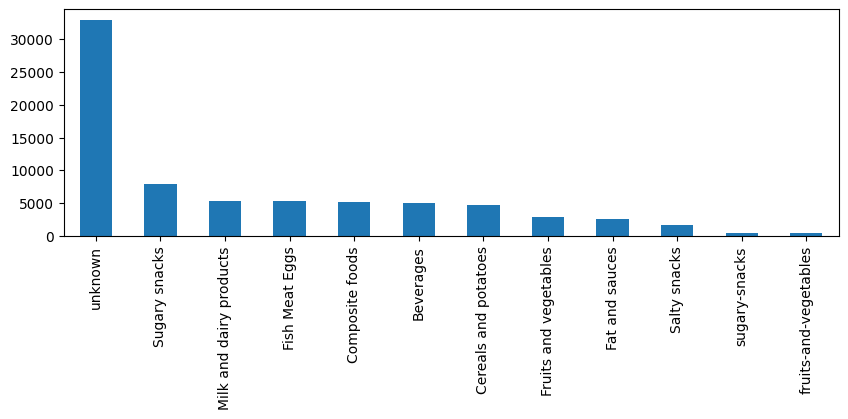

In [76]:
fig,ax = plt.subplots(1,1,figsize=(10,3),dpi=100,num=1)
Cleaned_Nutrition_Data_FR["pnns_groups_1"].value_counts(normalize=False).plot(kind='bar')
plt.show()

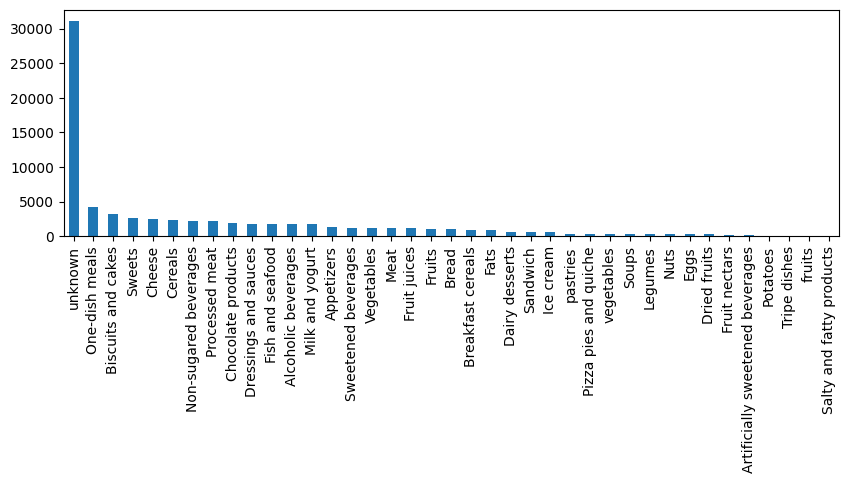

In [77]:
fig,ax = plt.subplots(1,1,figsize=(10,3),dpi=100,num=1)
Cleaned_Nutrition_Data_FR["pnns_groups_2"].value_counts(normalize=False).plot(kind='bar')
plt.show()

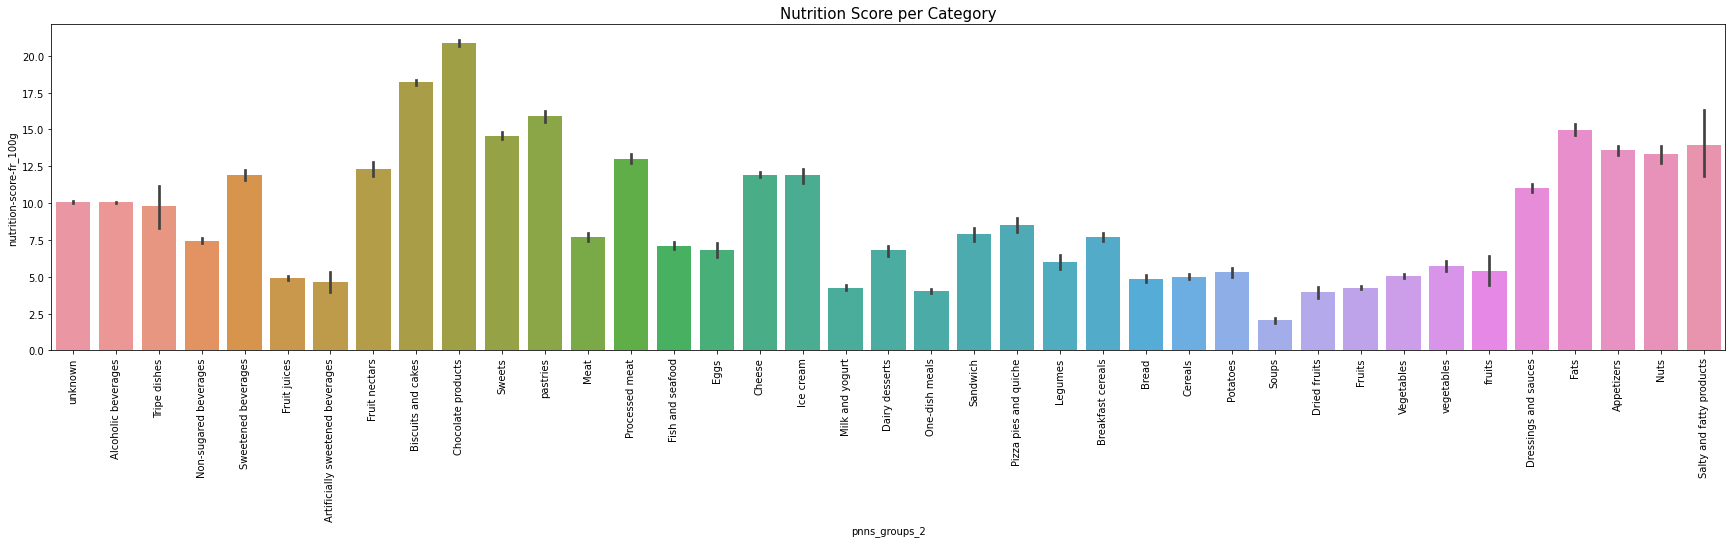

In [78]:
plt.figure(figsize=(30, 6))
plt.title('Nutrition Score per Category', size=15)
plot = sns.barplot(x = Cleaned_Nutrition_Data_FR['pnns_groups_2'], 
                   y = Cleaned_Nutrition_Data_FR['nutrition-score-fr_100g'])
plt.xticks(rotation=90)
plt.show()

I can't see a lot of logic for nutrition scores in our dataset, chocolate products have a high nutrition score when they should be low. I would expect vegetables to have a high score, but they seem average.

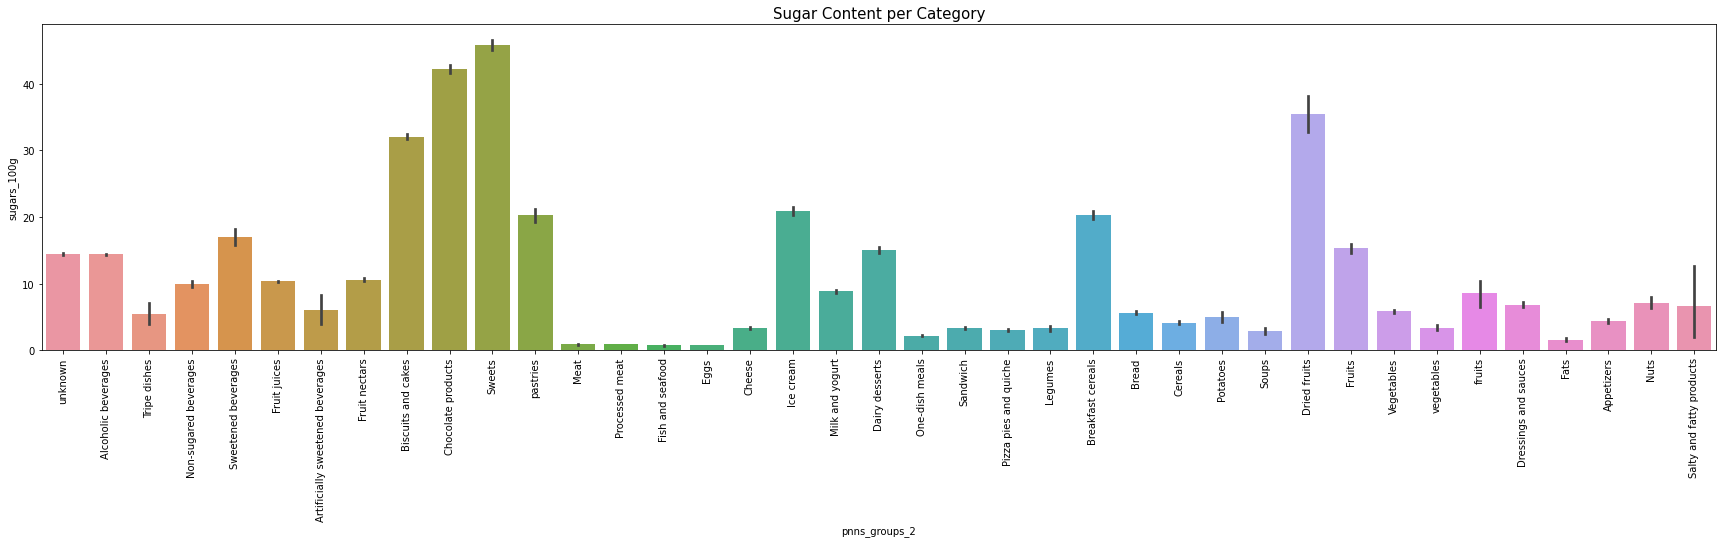

In [79]:
plt.figure(figsize=(30, 6))
plt.title('Sugar Content per Category', size=15)
plot = sns.barplot(x = Cleaned_Nutrition_Data_FR['pnns_groups_2'], 
                   y = Cleaned_Nutrition_Data_FR['sugars_100g'])
plt.xticks(rotation=90)
plt.show()

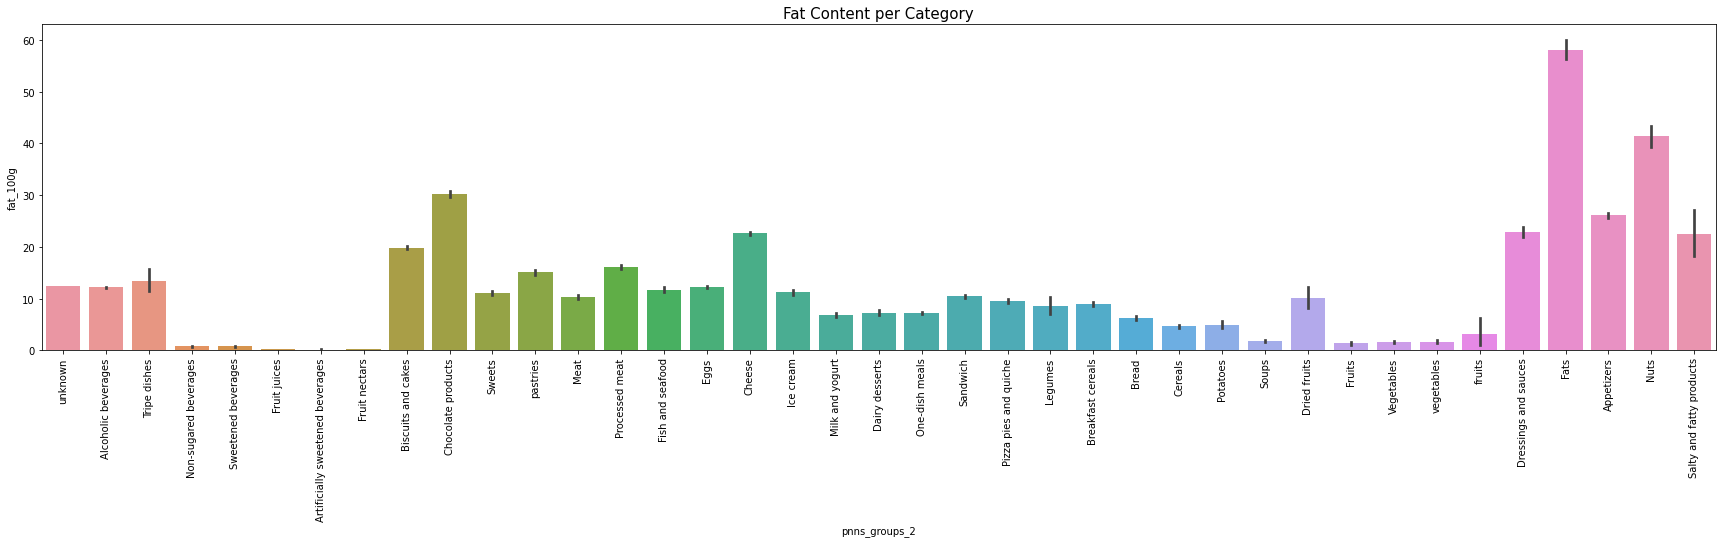

In [80]:
plt.figure(figsize=(30, 6))
plt.title('Fat Content per Category', size=15)
plot = sns.barplot(x = Cleaned_Nutrition_Data_FR['pnns_groups_2'], 
                   y = Cleaned_Nutrition_Data_FR['fat_100g'])
plt.xticks(rotation=90)
plt.show()

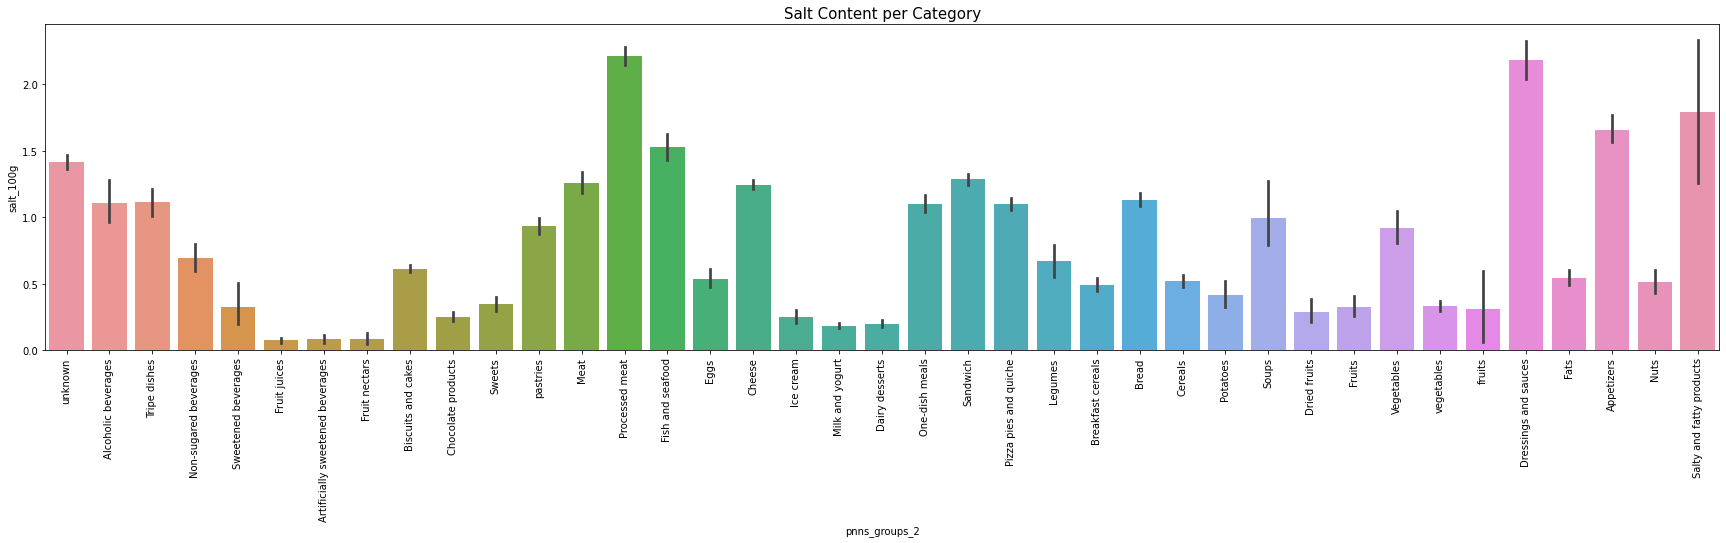

In [81]:
plt.figure(figsize=(30, 6))
plt.title('Salt Content per Category', size=15)
plot = sns.barplot(x = Cleaned_Nutrition_Data_FR['pnns_groups_2'], 
                   y = Cleaned_Nutrition_Data_FR['salt_100g'])
plt.xticks(rotation=90)
plt.show()

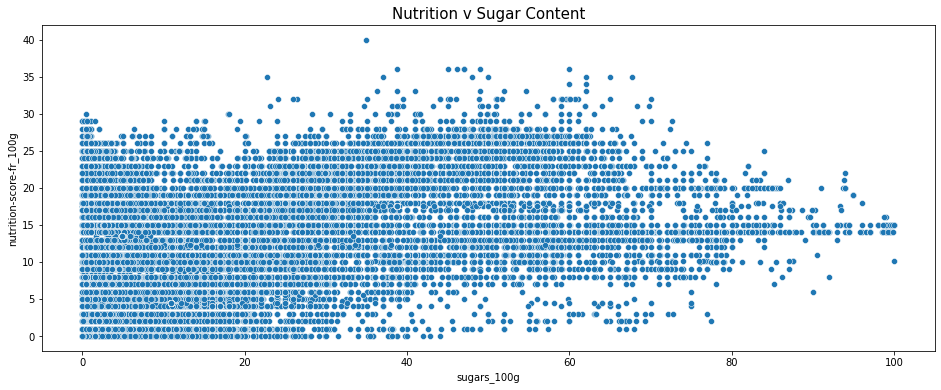

In [82]:
plt.figure(figsize=(16, 6))
plt.title('Nutrition v Sugar Content', size=15)
plot = sns.scatterplot(x = Cleaned_Nutrition_Data_FR["sugars_100g"],
                   y = Cleaned_Nutrition_Data_FR["nutrition-score-fr_100g"])
plt.show()

In [83]:
print(st.pearsonr(Cleaned_Nutrition_Data_FR["nutrition-score-fr_100g"],Cleaned_Nutrition_Data_FR["sugars_100g"])[0])
print(np.cov(Cleaned_Nutrition_Data_FR["nutrition-score-fr_100g"],Cleaned_Nutrition_Data_FR["sugars_100g"],ddof=0)[1,0])

0.48540058658427665
50.32925180968515


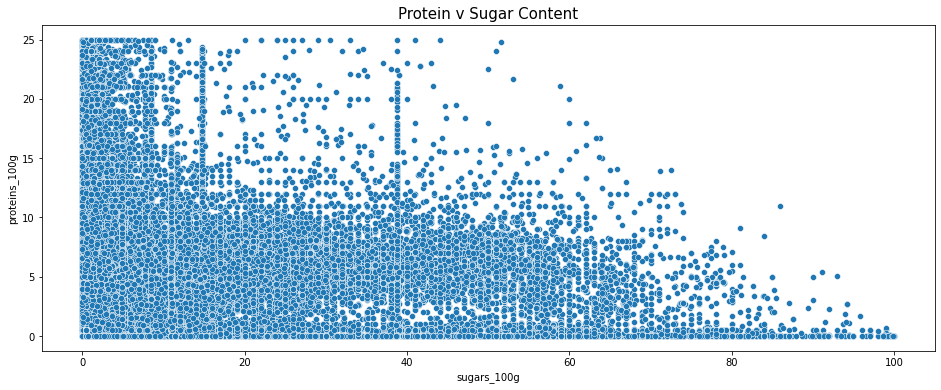

In [84]:
plt.figure(figsize=(16, 6))
plt.title('Protein v Sugar Content', size=15)
plot = sns.scatterplot(x = Cleaned_Nutrition_Data_FR["sugars_100g"], 
                   y = Cleaned_Nutrition_Data_FR["proteins_100g"])
plt.show()

In [85]:
print(st.pearsonr(Cleaned_Nutrition_Data_FR["proteins_100g"],Cleaned_Nutrition_Data_FR["sugars_100g"])[0])
print(np.cov(Cleaned_Nutrition_Data_FR["proteins_100g"],Cleaned_Nutrition_Data_FR["sugars_100g"],ddof=0)[1,0])

-0.2248882120237459
-20.823761748468456


In [86]:
Cleaned_Nutrition_Data_FR = Nutriscore(Cleaned_Nutrition_Data_FR)

In [87]:
Indicators = Cleaned_Nutrition_Data_FR.value_counts('Nutrigrade')
print(Indicators)

Nutrigrade
C    21072
D    15406
E    14625
B    13441
A     9809
dtype: int64


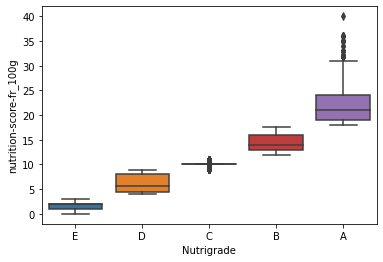

In [88]:
Cleaned_Nutrition_Data_FR['Nutrigrade'] = pd.cut(Cleaned_Nutrition_Data_FR['nutrition-score-fr_100g'],
                     bins=[0, 4, 9, 12, 18, 100],
                     labels=['E', 'D', 'C', 'B', 'A'],
                     right=False)

sns.boxplot(x="Nutrigrade", y="nutrition-score-fr_100g", data=Cleaned_Nutrition_Data_FR)
plt.show()

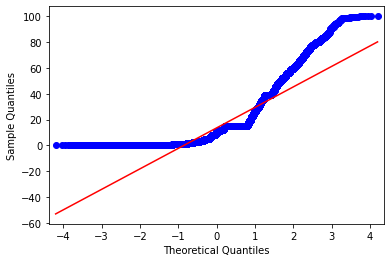

In [89]:
# QQ Plot
qqplot(Cleaned_Nutrition_Data_FR['sugars_100g'], line='s')
pyplot.show()

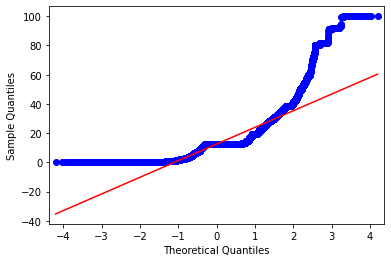

In [90]:
# QQ Plot
qqplot(Cleaned_Nutrition_Data_FR['fat_100g'], line='s')
pyplot.show()

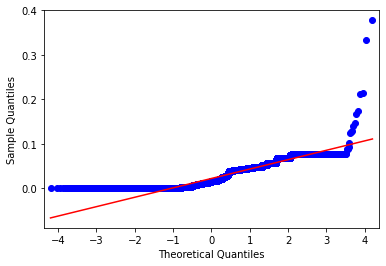

In [91]:
qqplot(Cleaned_Nutrition_Data_FR['cholesterol_100g'], line='s')
pyplot.show()


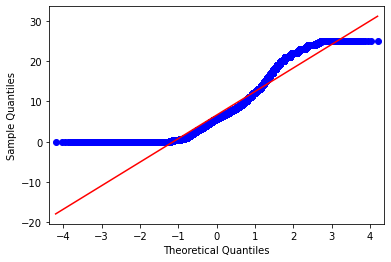

In [92]:
qqplot(Cleaned_Nutrition_Data_FR['proteins_100g'], line='s')
pyplot.show()

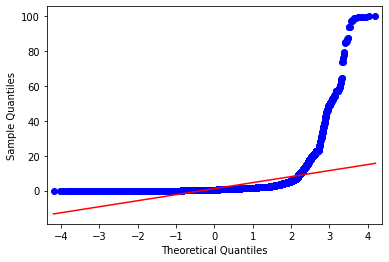

In [93]:
qqplot(Cleaned_Nutrition_Data_FR['salt_100g'], line='s')
pyplot.show()

In [94]:
Cleaned_Nutrition_Data_FR.corr()

,Unnamed: 0,nutrition-score-fr_100g,sugars_100g,fat_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,ingredients_from_palm_oil_n,cholesterol_100g,proteins_100g,salt_100g,Total
Unnamed: 0,1.000000,-0.111195,-0.170592,0.064542,0.000955,-0.006548,0.020999,0.069931,0.020193,0.055231,-0.050525,-0.089416
nutrition-score-fr_100g,-0.111195,1.000000,0.485401,0.507936,0.004756,-0.000341,0.002351,0.194399,-0.036077,0.059077,0.077074,0.691442
sugars_100g,-0.170592,0.485401,1.000000,0.050786,-0.002557,-0.002597,-0.012275,0.147275,-0.015834,-0.224888,-0.084836,0.727577
fat_100g,0.064542,0.507936,0.050786,1.000000,0.017377,-0.005205,0.021767,0.131086,-0.030809,0.113841,0.012977,0.633066
vitamin-a_100g,0.000955,0.004756,-0.002557,0.017377,1.000000,0.086686,0.522647,0.024200,-0.003917,-0.006588,-0.002037,0.009701
vitamin-c_100g,-0.006548,-0.000341,-0.002597,-0.005205,0.086686,1.000000,0.071781,0.000787,-0.004366,-0.005431,-0.001542,0.011711
calcium_100g,0.020999,0.002351,-0.012275,0.021767,0.522647,0.071781,1.000000,0.022807,0.001073,0.036041,-0.003959,0.018606
ingredients_from_palm_oil_n,0.069931,0.194399,0.147275,0.131086,0.024200,0.000787,0.022807,1.000000,-0.022664,-0.022265,0.016517,0.184372
cholesterol_100g,0.020193,-0.036077,-0.015834,-0.030809,-0.003917,-0.004366,0.001073,-0.022664,1.000000,0.103607,0.001981,0.001415
proteins_100g,0.055231,0.059077,-0.224888,0.113841,-0.006588,-0.005431,0.036041,-0.022265,0.103607,1.000000,0.113210,0.194214


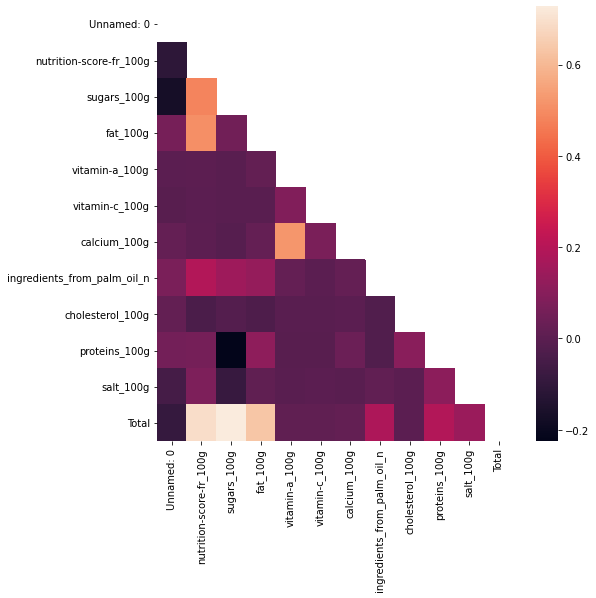

In [95]:
plt.figure(figsize=(8, 8))
mask = np.triu(np.ones_like(Cleaned_Nutrition_Data_FR.corr(), dtype=bool))
sns.heatmap(Cleaned_Nutrition_Data_FR.corr(), mask = mask);

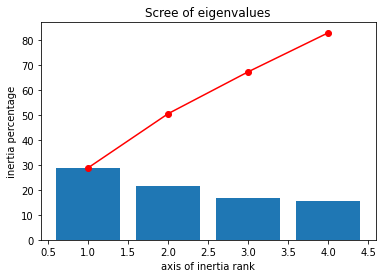

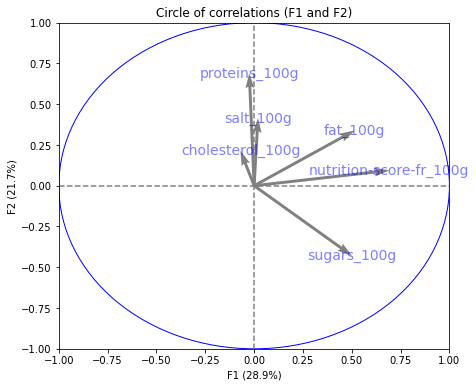

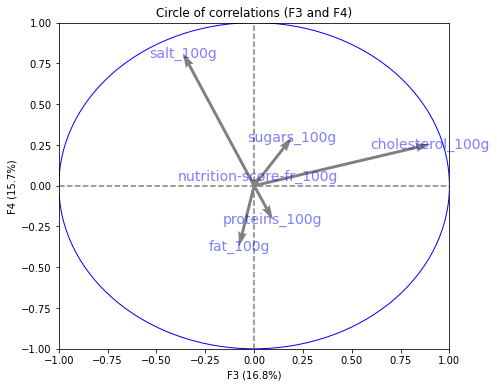

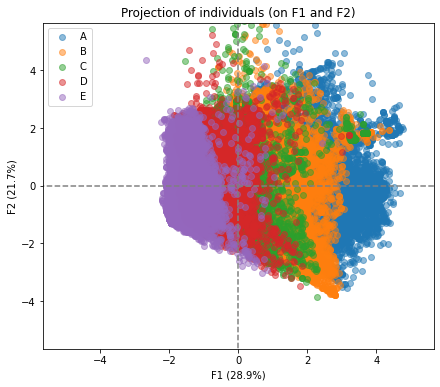

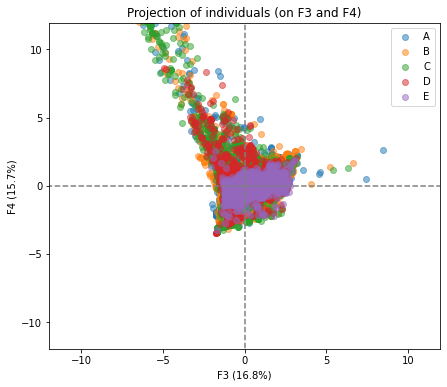

In [96]:
names = Cleaned_Nutrition_Data_FR["Nutrigrade"]
data_pca = Cleaned_Nutrition_Data_FR[['nutrition-score-fr_100g', 'sugars_100g', 'fat_100g', 'cholesterol_100g', 'proteins_100g', 'salt_100g']]
n_comp = 4

PCA_Analysis(names, data_pca, n_comp)


In [97]:
OLS_Regression()

                            OLS Regression Results                            
Dep. Variable:                     NS   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 1.445e+04
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        09:38:01   Log-Likelihood:            -2.1984e+05
No. Observations:               74353   AIC:                         4.397e+05
Df Residuals:                   74347   BIC:                         4.397e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.9438      0.040  

In [98]:
anova_NS = smf.ols('NS~pnns_groups_2', data=Cleaned_Nutrition_Data_FR).fit()
print(anova_NS.summary())

                            OLS Regression Results                            
Dep. Variable:                     NS   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     1021.
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        09:38:01   Log-Likelihood:            -2.2946e+05
No. Observations:               74353   AIC:                         4.590e+05
Df Residuals:                   74314   BIC:                         4.593e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [99]:
sm.stats.anova_lm(anova_NS, typ=2)

,sum_sq,df,F,PR(>F)
pnns_groups_2,1.089401e+06,38.0,1021.323021,0.0
Residual,2.085988e+06,74314.0,NaN,NaN


Conclusion:

The original data set contained many NaN values, outsiders and unreliable data

40% of data is of unknown food groups

Nutrition data graphs imply that chocolate products are most nutritious

Correlation data shows little correlation even where it would be expected

The QQ plots don't show much normal distribution

All in all I don't believe the data set is sufficiently reliable to help a user make improved healthy eating decisions